# Panan01 Bottom Water

In [1]:
import dask.distributed as dsk
import glob
import intake
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xesmf as xe

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
import logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)

In [3]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/36761/status,
Dashboard: /proxy/36761/status,Workers: 28
Total threads: 28,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42279,Workers: 28
Dashboard: /proxy/36761/status,Total threads: 28
Started: Just now,Total memory: 126.00 GiB
Comm: tcp://127.0.0.1:34953,Total threads: 1
Dashboard: /proxy/40905/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:38067,


In [4]:
pathsC = np.sort(glob.glob('/g/data/ik11/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/*/*.ocean_month_z.nc'))[-66:]
pathsM = np.sort(glob.glob('/g/data/g40/akm157/model_output/mom6-panan/panant-01-zstar-ssp126-MW-only/*/*.ocean_month_z.nc'))

In [5]:
shelf_mask = shelf_mask = xr.open_dataset('/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc')['contour_masked_above']

In [6]:
areaC = xr.open_dataset('/g/data/ik11/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['areacello'].sel(yh=slice(None,-59))
areaM = xr.open_dataset('/g/data/g40/akm157/model_output/mom6-panan/panant-01-zstar-ssp126-MW-only/output020/20010101.ocean_static.nc')['areacello'].sel(yh=slice(None,-59))

In [7]:
def preprocess(ds):
    ds = ds['agessc'].sel(yh=slice(None,-59))
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess, chunks = 'auto')
melt = xr.open_mfdataset(pathsM, preprocess = preprocess, chunks = 'auto')

In [8]:
ageC = cont['agessc']
ageM = melt['agessc']

In [9]:
ageC_mean = ageC.mean(dim='time')
ageM_mean = ageM.mean(dim='time')

In [10]:
bottom_maskC = ageC_mean.where(~np.isfinite(ageC_mean.shift({'z_l': -1})))
bottom_maskC = ~np.isnan(bottom_maskC)

In [11]:
bottom_maskM = ageM_mean.where(~np.isfinite(ageM_mean.shift({'z_l': -1})))
bottom_maskM = ~np.isnan(bottom_maskM)

In [12]:
botage_cont = ageC_mean.where(bottom_maskC).sum(dim='z_l')
botage_pert = ageM_mean.where(bottom_maskM).sum(dim='z_l')
botage_anom = botage_pert - botage_cont

In [13]:
botage_anom = botage_anom.load()

In [14]:
botage_cont = botage_cont.load()

In [15]:
botage_pert = botage_pert.load()

In [16]:
import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

In [17]:
depth = xr.open_dataset('/g/data/ik11/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['deptho']
land_mask = (0 * depth).fillna(1)

land = xr.where(np.isnan(depth.rename('land')), 1, np.nan)

land_50m = cft.NaturalEarthFeature("physical", "land", "50m", edgecolor="black", facecolor="papayawhip", linewidth=0.5)
projection = ccrs.SouthPolarStereo()

In [18]:
botage_cont.max()

<xarray.DataArray 'agessc' ()> Size: 8B
array(15.49785805)

In [19]:
botage_pert.max()

<xarray.DataArray 'agessc' ()> Size: 8B
array(14.997859)

In [20]:
botage_anom.max()

<xarray.DataArray 'agessc' ()> Size: 8B
array(4.65261793)

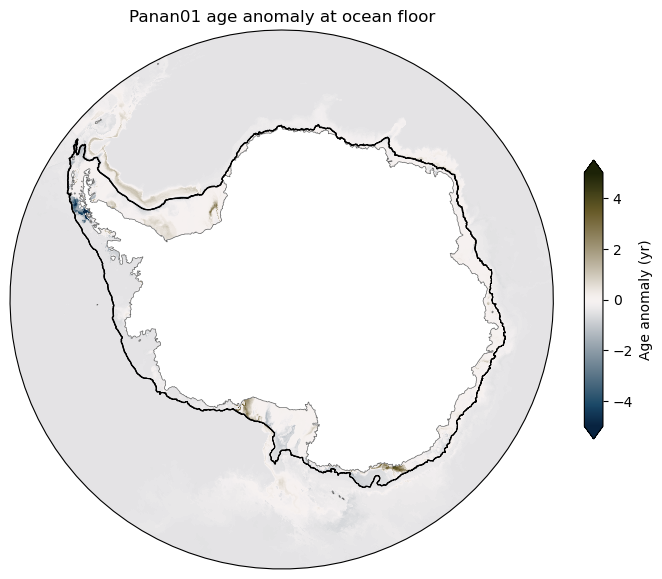

In [23]:
plt.figure(figsize=(8, 7))
ax = plt.axes(projection=projection)

ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())

#Compute a circle in axes coordinates, which we can use as a boundary for the map. 
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Filled land 
land.plot.contourf(ax=ax, colors='white',
                   zorder=2,
                   transform=ccrs.PlateCarree(),
                   add_colorbar=False)

#contours

ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'k', linewidths=0.5,transform = ccrs.PlateCarree())

botage_anom.plot(
    x="xh",
    y="yh",
    transform=ccrs.PlateCarree(),
    vmin=-5,
    vmax=5,
    extend="both",
    cmap=cm.cm.diff, #cm ocean colour maps for more options, matplotlib has more also.
    cbar_kwargs={"label": "Age anomaly (yr)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

plt.title("Panan01 age anomaly at ocean floor");

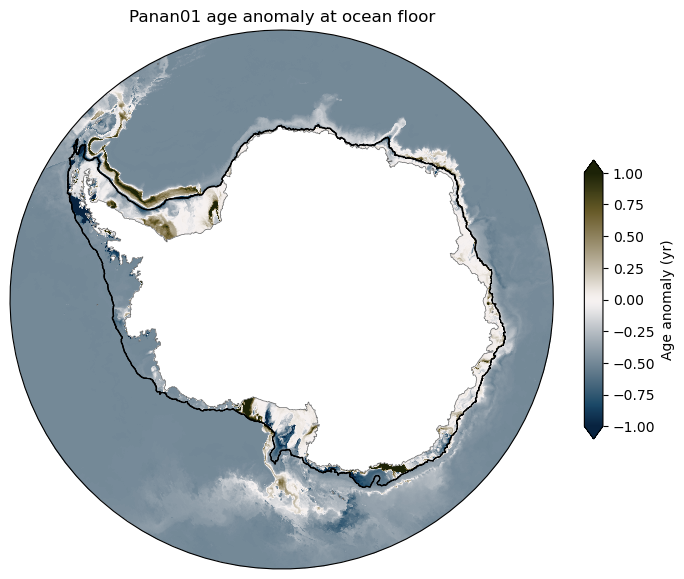

In [25]:
plt.figure(figsize=(8, 7))
ax = plt.axes(projection=projection)

ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())

#Compute a circle in axes coordinates, which we can use as a boundary for the map. 
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Filled land 
land.plot.contourf(ax=ax, colors='white',
                   zorder=2,
                   transform=ccrs.PlateCarree(),
                   add_colorbar=False)

#contours

ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'k', linewidths=0.5,transform = ccrs.PlateCarree())

botage_anom.plot(
    x="xh",
    y="yh",
    transform=ccrs.PlateCarree(),
    vmin=-1,
    vmax=1,
    extend="both",
    cmap=cm.cm.diff, #cm ocean colour maps for more options, matplotlib has more also.
    cbar_kwargs={"label": "Age anomaly (yr)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

plt.title("Panan01 age anomaly at ocean floor");

## Trying again with different bottom cell definition